# Classify snow-covered area (SCA) in Sentinel-2, Landsat 8/9, and PlanetScope imagery: full pipelines

Rainey Aberle

Department of Geosciences, Boise State University

2022

### Requirements:
- Area of Interest (AOI) shapefile: used to query and crop imagery 
- Google Earth Engine (GEE) account: used to query imagery and the DEM (if no DEM is provided). Sign up for a free account [here](https://earthengine.google.com/new_signup/). 
- Digital elevation model (DEM; _optional_): used to extract elevations over the AOI and for each snowline. If no DEM is provided, the ArcticDEM Mosaic will be used where there is coverage; otherwise, the NASADEM will be used.
- PlanetScope 4-band Surface Reflectance images (_optional_): download using the `Planet_images_order_download.ipynb` or through Planet Explorer. 

### Outline:
__0. Setup__ paths in directory, file locations, authenticate GEE - _modify this section!_

__1. Sentinel-2 Top of Atmosphere (TOA) imagery:__ full pipeline

__2. Sentinel-2 Surface Reflectance (SR) imagery:__ full pipeline

__3. Landsat 8/9 Surface Reflectance (SR) imagery:__ full pipeline

__4. PlanetScope Surface Reflectance (SR) imagery:__ full pipeline

-------


### 0. Setup

#### Define paths in directory and desired settings. 
Modify lines located within the following:

`#### MODIFY HERE ####`  

`#####################`

In [1]:
##### MODIFY HERE #####
# -----Paths in directory
site_name = '31854' # used for output file names
# path to glacier-snow-cover-mapping code
base_path = '/Users/ellynenderlin/Research/miscellaneous/glacier-snow-cover-mapping'
# path to AOI file
# aoi_fn = f'/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/{site_name}/AOIs/{site_name}_outline.shp'
aoi_fn = '/Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/AOIs/glims_polygons.shp'
# path to folder containing DEM raster file
# dem_path = f'/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/{site_name}/DEMs'
dem_path = '/Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/DEMs'
# DEM file name
# Note: set dem_fn=None if you want to use the ArcticDEM or NASADEM via Google Earth Engine
# dem_fn = None
dem_fn = '47_09_2_2_2m_v4.1_dem.tif'
# path for output images
# out_path = f'/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/{site_name}'
out_path = '/Users/ellynenderlin/Research/miscellaneous/GLIMS/31854'
# path to PlanetScope images
# Note: set ps_im_path=None if not using PlanetScope
# ps_im_path = f'/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/{site_name}/PlanetScope/raw_images'
ps_im_path = f'/Volumes/Jokulhaup_5T/Planetscope'
# path for output figures
# figures_out_path = f'/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/{site_name}/figures'
figures_out_path = '/Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures'

# -----Determine whether to mask clouds using the respective cloud masking data products
# NOTE: Cloud mask products anecdotally are less accurate over glacierized/snow-covered surfaces. 
# If the cloud masks are consistently masking large regions or your study site, I suggest testing with mask_clouds = False
mask_clouds = True

# -----Define image search filters
date_start = '2020-08-01'
date_end = '2025-03-31'
month_start = 3 #starts at the beginning of this month
month_end = 10 #goes through this month
cloud_cover_max = 70 # maximum cloud cover percentage according to the image metadata
aoi_coverage = 60 # total portion of AOI covered after filtering clouds

# -----Determine image download, clipping & plotting settings
# Note: if im_download = False, but images over the aoi exceed GEE limit, images must be downloaded regardless.
im_download = False  # = True to download all satellite images by default
plot_results = True # = True to plot figures of results for each image where applicable
verbose = True # = True to print details for each image during each step
skip_clipped = False # = True to skip PlanetScope images where bands appear "clipped", i.e. max(blue) < 0.8

#######################

# -----Import packages
import xarray as xr
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import sys
import ee
import json
from tqdm.auto import tqdm
from joblib import load
from shapely.geometry import MultiPolygon, Polygon
import warnings
warnings.filterwarnings('ignore')

# -----Make output directory if it doesn't exist
if not os.path.exists(out_path):
    os.mkdir(out_path)
    print('Made directory for outputs: ', out_path)

# -----Set paths for output files
s2_toa_im_path = os.path.join(out_path, 'Sentinel-2_TOA')
s2_sr_im_path = os.path.join(out_path, 'Sentinel-2_SR')
l_im_path = os.path.join(out_path, 'Landsat')
ps_im_masked_path = os.path.join(out_path, 'PlanetScope', 'masked')
ps_im_mosaics_path = os.path.join(out_path, 'PlanetScope', 'mosaics')
im_classified_path = os.path.join(out_path, 'classified')
stats_path = os.path.join(out_path, 'snow_cover_stats')

# -----Add path to functions
sys.path.insert(1, os.path.join(base_path, 'functions'))
import pipeline_utils as f
import PlanetScope_preprocessing as psp

# -----Load dataset dictionary
dataset_dict_fn = os.path.join(base_path, 'inputs-outputs', 'datasets_characteristics.json')
dataset_dict = json.load(open(dataset_dict_fn))

#### Authenticate and initialize Google Earth Engine (GEE). 

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back into the space below this cell when prompted. 

In [4]:
# Replace project with your GEE project. Default = 'ee-[GEE-USERNAME]'
try:
    ee.Initialize(project='ee-ellynenderlinresearch')
except: 
    ee.Authenticate()
    ee.Initialize(project='ee-ellynenderlinresearch')

#### Load AOI and DEM

<Axes: >

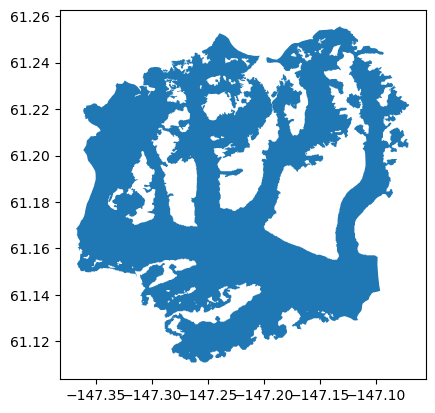

In [26]:
# load the polygon
aoi = gpd.read_file(aoi_fn)
# reproject the AOI to WGS84 to solve for the optimal utm zone
aoi_wgs = aoi.to_crs('EPSG:4326')

#if you need to filter the polygons because there are lots
# aoi_wgs = aoi_wgs.loc[aoi['area']>100] #filter by area (used for Columbia glacier)
# aoi_wgs.keys() #shows all column names
# aoi_wgs['glac_name'] #double check that the name for the identified glaciers makes sense

# pick the best aoi
# aoi_wgs = gpd.GeoDataFrame(aoi_wgs.iloc[1271],geometry='geometry').transpose() #attempt to specify index but didn't work!
aoi_wgs = aoi_wgs.loc[aoi_wgs['area']==129.755].reset_index() #reset the index so it is now flat (index will be 0)
aoi_wgs.plot()


Optimal UTM CRS = EPSG:32606


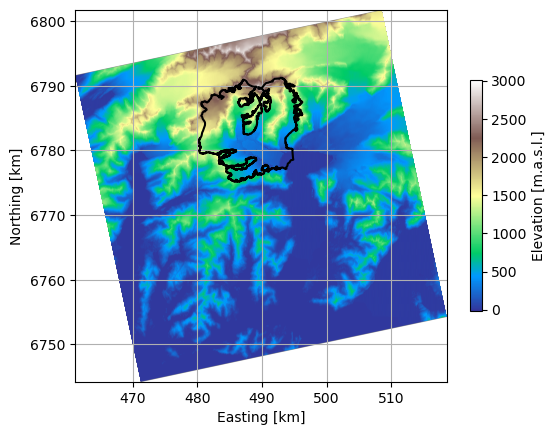

In [34]:
# -----Convert AOI to gpd.GeoDataFrame
aoi_wgs_centroid = [aoi_wgs.geometry[0].centroid.xy[0][0],
                    aoi_wgs.geometry[0].centroid.xy[1][0]]
# grab the optimal UTM zone EPSG code
epsg_utm = f.convert_wgs_to_utm(aoi_wgs_centroid[0], aoi_wgs_centroid[1])
print('Optimal UTM CRS = EPSG:' + str(epsg_utm))
# reproject AOI to the optimal UTM zone
aoi_utm = aoi_wgs.to_crs('EPSG:'+epsg_utm)

# -----Load DEM as Xarray DataSet
if dem_fn is None:
    # query GEE for DEM
    dem = f.query_gee_for_dem(aoi_utm, base_path, site_name, dem_path) #defaults to the ArcticDEM if there is coverage, otherwise it queries the NASADEM
else:
    # load DEM as xarray DataSet
    dem = xr.open_dataset(os.path.join(dem_path, dem_fn))
    dem_crs = str(dem.rio.crs.to_epsg())
    dem = f.adjust_dem_data_vars(dem)
    # set no data values to NaN
    dem = xr.where((dem > 1e38) | (dem <= -9999), np.nan, dem)
    # reproject the DEM to the optimal utm zone
    dem = dem.rio.write_crs('EPSG:' + dem_crs)
    if dem_crs is not epsg_utm:
        dem = dem.rio.reproject('EPSG:' + epsg_utm).rio.write_crs('EPSG:'+str(epsg_utm))

# -----Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dem_im = ax.imshow(dem.elevation.data, cmap='terrain', 
          extent=(np.min(dem.x.data)/1e3, np.max(dem.x.data)/1e3, np.min(dem.y.data)/1e3, np.max(dem.y.data)/1e3))
if type(aoi_utm.geometry[0])==Polygon:
    ax.plot([x/1e3 for x in aoi_utm.geometry[0].exterior.coords.xy[0]],
            [y/1e3 for y in aoi_utm.geometry[0].exterior.coords.xy[1]], '-k')
elif type(aoi_utm.geometry[0])==MultiPolygon:
    [ax.plot([x/1e3 for x in geom.exterior.coords.xy[0]],
            [y/1e3 for y in geom.exterior.coords.xy[1]], '-k') for geom in aoi_utm.geometry[0].geoms]
ax.grid()
ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')
fig.colorbar(dem_im, ax=ax, shrink=0.5, label='Elevation [m.a.s.l.]')
plt.show()

## 1. Sentinel-2 TOA imagery

Sentinel-2 SR imagery is only available starting ~2019, so run Sentinel-2 TOA pipeline if needing observations before 2019.

In [35]:
# -----Query GEE for imagery and run classification pipeline
# Define dataset
dataset = 'Sentinel-2_TOA'
# Load trained image classifier
clf_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_TOA_classifier_all_sites.joblib')
clf = load(clf_fn)
# Load feature columns (bands to use in classification)
feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_TOA_feature_columns.json')
feature_cols = json.load(open(feature_cols_fn))
# Run the classification pipeline
run_pipeline=True
f.query_gee_for_imagery(dataset_dict, dataset, aoi_utm, dem, date_start, date_end, month_start, month_end, 
                        mask_clouds, cloud_cover_max, aoi_coverage, run_pipeline, site_name, 
                        clf, feature_cols, im_download, s2_toa_im_path, im_classified_path, 
                        stats_path, figures_out_path, plot_results, verbose)
                                        

Sentinel-2_TOA images must be downloaded for full spatial resolution
Splitting full date range into annual date ranges
Iterating over date ranges

['2020-08-01', '2020-10-31']
Querying GEE for all images meeting search criteria...
28 total images found
17 total images will remain after mosaicking


  0%|          | 0/17 [00:00<?, ?it/s]

Made directory for image downloads: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/Sentinel-2_TOA


Sentinel-2_TOA_20201011.tif: |                      | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b438.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b410.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b2f8.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b348.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b280.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b1b8.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b2d0.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b230.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b3e8.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4b2c8b320.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _

Image covers < 60% of the AOI, skipping...


Sentinel-2_TOA_20200804_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a2e78.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a2f68.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a2f90.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a3058.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a3080.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a2f18.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a30a8.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a2ef0.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a2fe0.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x7ff4e10a3210.tif: Bad value 12 for "ExtraSamples" tag
ERROR 1: _

Image covers < 60% of the AOI, skipping...


Sentinel-2_TOA_20201028_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Made directory for classified images: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified
Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20201028T151815_31854_Sentinel-2_TOA_classified.nc
Made directory for snowlines: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats
Made directory for output figures:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20201028T151815_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0618..2.8].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20201028T151815_31854_Sentinel-2_TOA_snow_cover.png


Sentinel-2_TOA_20200807.tif: |                      | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Image covers < 60% of the AOI, skipping...


Sentinel-2_TOA_20200911_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20200911T152812_31854_Sentinel-2_TOA_classified.nc
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20200911T152812_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0283..1.6831].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20200911T152812_31854_Sentinel-2_TOA_snow_cover.png


Sentinel-2_TOA_20201013_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20201013T151818_31854_Sentinel-2_TOA_classified.nc
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20201013T151818_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0453..2.5227].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20201013T151818_31854_Sentinel-2_TOA_snow_cover.png


Sentinel-2_TOA_20201016_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20201016T152815_31854_Sentinel-2_TOA_classified.nc
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20201016T152815_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.045..2.5989].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20201016T152815_31854_Sentinel-2_TOA_snow_cover.png


Sentinel-2_TOA_20201021_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20201021T152813_31854_Sentinel-2_TOA_classified.nc
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20201021T152813_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0455..2.622].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20201021T152813_31854_Sentinel-2_TOA_snow_cover.png


Sentinel-2_TOA_20200822_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20200822T152813_31854_Sentinel-2_TOA_classified.nc
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20200822T152813_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.031..1.4355].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20200822T152813_31854_Sentinel-2_TOA_snow_cover.png


Sentinel-2_TOA_20200817_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20200817T152816_31854_Sentinel-2_TOA_classified.nc
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20200817T152816_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0316..1.337].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20200817T152816_31854_Sentinel-2_TOA_snow_cover.png


Sentinel-2_TOA_20200829.tif: |                      | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Image covers < 60% of the AOI, skipping...


Sentinel-2_TOA_20200814_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20200814T151818_31854_Sentinel-2_TOA_classified.nc
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20200814T151818_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0454..1.4557].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20200814T151818_31854_Sentinel-2_TOA_snow_cover.png


Sentinel-2_TOA_20200913_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20200913T151816_31854_Sentinel-2_TOA_classified.nc
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20200913T151816_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0299..1.7267].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20200913T151816_31854_Sentinel-2_TOA_snow_cover.png


Sentinel-2_TOA_20201008.tif: |                      | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Image covers < 60% of the AOI, skipping...


Sentinel-2_TOA_20200906.tif: |                      | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Image covers < 60% of the AOI, skipping...


Sentinel-2_TOA_20200827.tif: |                      | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Image covers < 60% of the AOI, skipping...


Sentinel-2_TOA_20200812_MOSAIC.tif: |               | 0.00/67.1M (raw) [  0.0%] in 00:00 (eta:     ?)

Classified image saved to file:  /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/classified/20200812T152813_31854_Sentinel-2_TOA_classified.nc
Snow cover staistics saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/snow_cover_stats/20200812T152813_31854_Sentinel-2_TOA_snow_cover_stats.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0499..1.5476].


Figure saved to file: /Users/ellynenderlin/Research/miscellaneous/GLIMS/31854/figures/20200812T152813_31854_Sentinel-2_TOA_snow_cover.png


## 2. Sentinel-2 SR imagery

In [ ]:
# -----Query GEE for imagery and run classification pipeline
# Define dataset
dataset = 'Sentinel-2_SR'
# Load trained image classifier
clf_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_SR_classifier_all_sites.joblib')
clf = load(clf_fn)
# Load feature columns (bands to use in classification)
feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_SR_feature_columns.json')
feature_cols = json.load(open(feature_cols_fn))
# Run the classification pipeline
run_pipeline=True
f.query_gee_for_imagery(dataset_dict, dataset, aoi_utm, dem, date_start, date_end, month_start, month_end, 
                        mask_clouds, cloud_cover_max, aoi_coverage, run_pipeline, site_name, 
                        clf, feature_cols, im_download, s2_sr_im_path, im_classified_path, 
                        stats_path, figures_out_path, plot_results, verbose)


## 3. Landsat 8/9 SR imagery

In [ ]:
# -----Query GEE for imagery (and download to l_im_path if necessary)
# Define dataset
dataset = 'Landsat'
# Load trained image classifier
clf_fn = os.path.join(base_path, 'inputs-outputs', 'Landsat_classifier_all_sites.joblib')
clf = load(clf_fn)
# Load feature columns (bands to use in classification)
feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'Landsat_feature_columns.json')
feature_cols = json.load(open(feature_cols_fn))
# Run the classification pipeline
run_pipeline=True
f.query_gee_for_imagery(dataset_dict, dataset, aoi_utm, dem, date_start, date_end, month_start, month_end, 
                        mask_clouds, cloud_cover_max, aoi_coverage, run_pipeline, site_name, 
                        clf, feature_cols, im_download, l_im_path, im_classified_path, 
                        stats_path, figures_out_path, plot_results, verbose)
         

## 4. PlanetScope SR imagery

### Pre-process raw imagery

In [ ]:
# -----Read surface reflectance image file names
os.chdir(ps_im_path)
im_fns = sorted(glob.glob('*SR*.tif'))

# ----Mask clouds and cloud shadows in all images
if mask_clouds:
    print('Masking images using cloud bitmask...')
    for im_fn in tqdm(im_fns):
        psp.planetscope_mask_image_pixels(ps_im_path, im_fn, ps_im_masked_path, plot_results=False)
# read masked image file names
os.chdir(ps_im_masked_path)
im_masked_fns = sorted(glob.glob('*_mask.tif'))

# -----Mosaic images captured within same hour
print('Mosaicking images captured in the same hour...')
if mask_clouds:
    psp.planetscope_mosaic_images_by_date(ps_im_masked_path, im_masked_fns, ps_im_mosaics_path, aoi_utm)
    print(' ')
else:
    psp.planetscope_mosaic_images_by_date(ps_im_path, im_fns, ps_im_mosaics_path, aoi_utm)
    print(' ')

### Run snow detection workflow

In [ ]:
# -----Load trained classifier and feature columns
clf_fn = os.path.join(base_path, 'inputs-outputs', 'PlanetScope_classifier_all_sites.joblib')
clf = load(clf_fn)
feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'PlanetScope_feature_columns.json')
feature_cols = json.load(open(feature_cols_fn))
dataset = 'PlanetScope'

# -----Iterate over image mosaics
# read image mosaic file names
os.chdir(ps_im_mosaics_path)
im_mosaic_fns = sorted(glob.glob('*.tif'))
# create polygon(s) of the top and bottom 20th percentile elevations within the AOI
polygons_top, polygons_bottom = psp.create_aoi_elev_polys(aoi_utm, dem)
# loop through images
for im_mosaic_fn in tqdm(im_mosaic_fns):

    # -----Determine image date from image mosaic file name
    im_date = im_mosaic_fn[0:4] + '-' + im_mosaic_fn[4:6] + '-' + im_mosaic_fn[6:8] + 'T' + im_mosaic_fn[9:11] + ':00:00'
    im_dt = np.datetime64(im_date)
    if verbose:
        print(im_date)

    # -----Open image mosaic
    im_da = xr.open_dataset(os.path.join(ps_im_mosaics_path, im_mosaic_fn))

    # -----Adjust radiometry
    im_adj, im_adj_method = psp.planetscope_adjust_image_radiometry(im_da, im_dt, polygons_top, polygons_bottom,
                                                                    dataset_dict, skip_clipped)
    if type(im_adj) is str:  # skip if there was an error in adjustment
        continue    
    
    # -----Check if classified image already exists in file
    # check if classified image already exists in file
    im_classified_fn = im_date.replace('-', '').replace(':',
                                                        '') + '_' + site_name + '_' + dataset + '_classified.nc'
    if os.path.exists(os.path.join(im_classified_path, im_classified_fn)):
        if verbose:
            print('Classified image already exists in file, loading...')
        im_classified = xr.open_dataset(os.path.join(im_classified_path, im_classified_fn))
        
        # remove no data values
        im_classified = xr.where(im_classified == -9999, np.nan, im_classified)
        # reproject to UTM
        im_classified = im_classified.rio.write_crs('EPSG:4326')
        im_classified = im_classified.rio.reproject('EPSG:' + epsg_utm)
    else:

        # -----Check that image mosaic covers at least aoi_coverage of the AOI
        # Create dummy band for AOI masking comparison
        im_adj['aoi_mask'] = (['time', 'y', 'x'], np.ones(np.shape(im_adj[dataset_dict[dataset]['RGB_bands'][0]].data)))
        im_aoi = im_adj.rio.clip(aoi_utm.geometry, im_adj.rio.crs)
        # Calculate the percentage of real values in the AOI    
        perc_real_values_aoi = (len(np.where(~np.isnan(np.ravel(im_aoi[dataset_dict[dataset]['RGB_bands'][0]].data)))[0])
                                / len(np.where(~np.isnan(np.ravel(im_aoi['aoi_mask'].data)))[0]))
        if perc_real_values_aoi < aoi_coverage:
            if verbose:
                print(f'Less than {aoi_coverage}% coverage of the AOI, skipping image...')
                print(' ')
            continue

        # -----Classify image
        im_classified = f.classify_image(im_adj, clf, feature_cols, aoi_utm, dataset_dict,
                                         dataset, im_classified_fn, im_classified_path, verbose)
        if type(im_classified) == str:
            continue

    # -----Delineate snowline(s)
    # check if snowline already exists in file
    snowline_fn = im_date.replace('-', '').replace(':', '') + '_' + site_name + '_' + dataset + '_snow_cover_stats.csv'
    if os.path.exists(os.path.join(stats_path, snowline_fn)):
        if verbose:
            print('Snowline already exists in file, skipping...')
            print(' ')
        continue    
    else:
        plot_results = True
        snowline_df = f.delineate_snowline(im_classified, site_name, aoi_utm, dem, dataset_dict,
                                           dataset, im_date, snowline_fn, stats_path, figures_out_path,
                                           plot_results, im_adj, verbose)
        plt.close()
        if verbose:
            print('Accumulation Area Ratio =  ' + str(snowline_df['AAR'][0]))
    if verbose:
        print(' ')